# NeuralNetwork

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

## 画像抽出
np.random.seed(13)
train_size = 1000
test_size = 102
rand_train_indices = np.random.choice(len(mnist.train.images), train_size, replace = False)
rand_test_indices = np.random.choice(len(mnist.test.images), test_size, replace = False)

x_vals_train = mnist.train.images[rand_train_indices]
x_vals_test = mnist.test.images[rand_test_indices]
y_vals_train = mnist.train.labels[rand_train_indices]
y_vals_test = mnist.test.labels[rand_test_indices]

/Users/daisuke/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/daisuke/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class NeuralNetwork():
    def __init__(self, x_train_data, y_train_data, hidden_layers_info=[300, 100],
                  act_func=['relu','relu'], loss_func='absolute', optimizer='adam', drop_out=False):
        self.sess = tf.Session()
        self.x_train_data = x_train_data
        self.y_train_data = y_train_data
        self.input_size = len(x_train_data[0])
        self.output_size = len(y_train_data[0])
        self.layers_info = [self.input_size] + hidden_layers_info + [self.output_size]
        self.act_func = act_func
        self.loss_func = loss_func
        self.optimizer = optimizer
        
        self.create_placeholder()
        self.init_weights()
       
        self.set_model()
        self.set_loss_func()
        self.set_optimize_func()
        self.train_step = self.my_opt.minimize(self.loss)
        
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', self.loss)
            self.merged = tf.summary.merge_all()
            self.writer = tf.summary.FileWriter('./logs', self.sess.graph)
        #変数を初期化
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
    def init_weights(self):
        weight_shapes = [[self.layers_info[i], self.layers_info[i+1]] for i in range(len(self.layers_info) - 1)]
        self.weights = [tf.Variable(tf.random_normal(shape, stddev=10.), name='weight_layer'+str(i+1)) for i,shape in enumerate(weight_shapes)]
        bias_shapes = [[self.layers_info[i+1]] for i in range(len(self.layers_info) - 1)]
        self.biases = [tf.Variable(tf.random_normal(shape, stddev=10.), name='bias_layer'+str(i+1)) for i,shape in enumerate(bias_shapes)]
        
    def create_placeholder(self):
        self.x_data = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32, name='input_data')
        self.y_target = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32, name='labels')
        
    def fully_connected(self, input_layer, weights, biases):
        return tf.add(tf.matmul(input_layer, weights), biases)
    
    def activation_func(self, input_layer, func_name):
        if func_name == 'relu':
            return tf.nn.relu(input_layer)
        elif func_name == 'sigmoid':
            return tf.nn.sigmoid(input_layer)
        elif func_name == 'tanh':
            return tf.nn.tanh(input_layer)
        elif func_name == 'softsign':
            return tf.nn.softsign(input_layer)
        return input_layer
    
    def set_model(self):
        self.layers = [None] * (len(self.layers_info) - 1)
        self.layers[0] = self.x_data
        for i in range(len(self.weights) - 1):
            with tf.name_scope('activation'+str(i+1)):
                self.layers[i+1] = self.activation_func(
                    self.fully_connected(self.layers[i], self.weights[i], self.biases[i]), 
                    self.act_func[0])
            
        with tf.name_scope('activation_fin'):
            self.final_output = self.activation_func(
                self.fully_connected(self.layers[-1], self.weights[-1], self.biases[-1]), 
                self.act_func[1])
        
    def set_loss_func(self):
        if self.loss_func == 'absolute':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.abs(self.y_target - self.final_output))
        elif self.loss_func == 'euclidean':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.square(self.y_target - self.final_output))
        elif self.loss_func == 'hinge':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.maximum(0., 1. - tf.multiply(self.y_target, self.final_output)))
        elif self.loss_func == 'cross_entropy':
            with tf.name_scope('loss'):
                self.loss = - tf.reduce_mean(tf.multiply(self.y_target, tf.log(self.final_output)) +
                                         tf.multiply((1. - self.y_target), tf.log(1. - self.final_output)))
    
    def set_optimize_func(self):
        if self.optimizer == 'gradient':
            self.my_opt = tf.train.GradientDescentOptimizer(0.05)
        elif self.optimizer == 'momentum':
            self.my_opt = tf.train.MomentumOptimizer(0.05)
        elif self.optimizer == 'adam':
            self.my_opt = tf.train.AdamOptimizer(0.05)
        elif self.optimizer == 'adagrad':
            self.my_opt = tf.train.AdagradOptimizer(0.05)
        elif self.optimizer == 'adadelta':
            self.my_opt = tf.train.AdadeltaOptimizer(0.05)
    
    def train(self, x_test_data, y_test_data, batch_size=10, epoch=100):
        self.batch_size = batch_size
        self.epoch = epoch
        self.loss_vec = []
        self.test_loss = []

        for i in range(self.epoch):
            rand_index = np.random.choice(len(self.x_train_data), size=self.batch_size)
            rand_x = self.x_train_data[rand_index]
            rand_y = self.y_train_data[rand_index]
            self.sess.run(self.final_output, feed_dict={self.x_data: rand_x, self.y_target: rand_y})
            
            self.sess.run(self.train_step, feed_dict={self.x_data: rand_x, self.y_target: rand_y})

            temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: rand_x, self.y_target: rand_y})
            self.loss_vec.append(temp_loss)

            test_temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: x_test_data, self.y_target: y_test_data})
            self.test_loss.append(test_temp_loss)

            if (i+1)%1 == 0:
                print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))
                
    def get_loss_vec(self):
        return self.loss_vec, self.test_loss
    

In [3]:
my_neural_model = NeuralNetwork(x_vals_train, y_vals_train, hidden_layers_info=[300, 100], act_func=['relu','relu'], 
                                loss_func='absolute', optimizer='adam', drop_out=False)

In [5]:
my_neural_model.train(x_vals_test, y_vals_test, batch_size=5, epoch=20)

Generation: 1. Loss = 0.1
Generation: 2. Loss = 0.1
Generation: 3. Loss = 0.1
Generation: 4. Loss = 0.1
Generation: 5. Loss = 0.1
Generation: 6. Loss = 0.1
Generation: 7. Loss = 0.1
Generation: 8. Loss = 0.1
Generation: 9. Loss = 0.1
Generation: 10. Loss = 0.1
Generation: 11. Loss = 0.1
Generation: 12. Loss = 0.1
Generation: 13. Loss = 0.1
Generation: 14. Loss = 0.1
Generation: 15. Loss = 0.1
Generation: 16. Loss = 0.1
Generation: 17. Loss = 0.1
Generation: 18. Loss = 0.1
Generation: 19. Loss = 0.1
Generation: 20. Loss = 0.1


In [18]:
loss_vec, test_loss = my_neural_model.get_loss_vec()

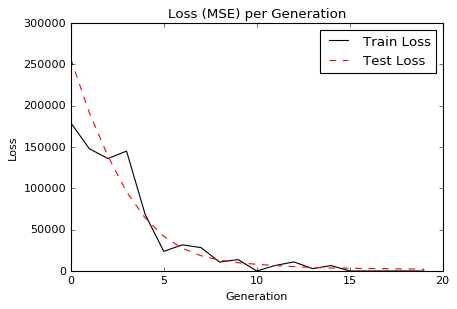

In [19]:
plt.plot(loss_vec, 'k-', label='Train Loss') 
plt.plot(test_loss, 'r--', label='Test Loss') 
plt.title('Loss (MSE) per Generation') 
plt.xlabel('Generation')
plt.ylabel('Loss') 
plt.legend(loc='upper right') 
plt.show()